# Tutorial for regression benchmarking

This code loads data and a design matrix, then benchmarks methods of ridge regression in terms of accuracy and speed, both for estimating the alpha(s) and for performing the cross-validated prediction.

Written by Michael Sokoletsky, 2023.


### Imports and options

In [1]:
import time
import itertools 

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer
from scipy.optimize import fminbound
from tqdm import tqdm

import regbench as rb

opts = {} # Intialize options dictionary
# Recording options
opts['dir'] = 'D:\Churchland\Widefield' # Path to directory in which the recording file is located
opts['rec_name'] = 'mSM63_09-Aug-2018' # Recording name
opts['frames_per_trial'] = 75 # Num of frames per trial
opts['dformat'] = 'MATLAB'
# Refression benchmarking options
opts['out_folds'] = 10 # Num of folds for outer (test) cross-validation
opts['in_folds'] = 5 # Num of folds for inner (train) cross-validation
opts['alpha_mets'] = ['Karabastos', 'RidgeCV', 'GridSearchCV', 'fminbound', 'None'] # Alpha estimation methods to test
opts['crossval_mets'] = ['Kaufman', 'Ridge', 'cross_val_predict'] # Cross-validation methods to test
opts['recenter'] = True # Whether to recenter the variables (no intercept) or not (fit intercept term) for all methods
opts['test_range'] =  np.concatenate([np.arange(1, 2000, 500),
                                      np.arange(3000, 13000,2000),
                                      np.arange(15000, 30000, 5000)]) # Range to test in cross-validated alpha estimation methods
opts['n_jobs'] = -1 # Num of concurrently running workers in cross-validated alpha estimation methods. -1 uses the full CPU capacity.
opts['xtol'] = 100 # Convergence tolerance for the fminbound alpha estimation method
opts['map_met'] = 'r2' # Method of mapping scores. Choices: 'r2', 'R2'
opts['sample_trials'] = 50# Number of trials to randomally sample for R2 map calculation. -1 uses all of them.

### Load data and design matrix

In [2]:
data = rb.load_data(opts) # Load widefield data
design = rb.load_design(opts) # Load design DataFrame
if opts['recenter']:
    design_norm = (design-design.mean())/design.std() # Normalize design DataFrrame
else:
    design_norm = design/design.std() # Normalize design DataFrrame
out_split, in_split = rb.split_by_trials(data, opts) # Split data into outer and inner folds by trials
calc_score = rb.mint_calc_score(data) # Mint a custom score function weighted by component loadings
scorer = make_scorer(calc_score) # Create a scorer based on this scoring function

### Benchmark methods of estimating alphas

In [4]:
alphas = {}
alpha_times = {}
train_idx, _ = out_split[0]
for alpha_method in tqdm(opts['alpha_mets'], desc='Alpha method num'):
    st = time.time()
    if alpha_method == 'Karabastos':
        alphas[alpha_method] = rb.ridge_MML(data.svt[train_idx, :], design_norm.loc[train_idx], regress=False)
    elif alpha_method == 'GridSearchCV':
        mdl = GridSearchCV(Ridge(), {'alpha': opts['test_range']}, cv=in_split, scoring=scorer, n_jobs=opts['n_jobs'], refit=False)
        mdl.fit(design_norm.loc[train_idx], data.svt[train_idx, :])
        alphas[alpha_method] = mdl.best_params_['alpha']
    elif alpha_method == 'RidgeCV':
        mdl = RidgeCV(alphas=opts['test_range'], scoring='r2', alpha_per_target=True)
        mdl.fit(design_norm.loc[train_idx], data.svt[train_idx, :])
        alphas[alpha_method] = mdl.alpha_
    elif alpha_method == 'fminbound':
        score_func = rb.mint_score_func(design_norm.loc[train_idx], data.svt[train_idx, :], cv=in_split,scoring=scorer, n_jobs=opts['n_jobs'])
        alphas[alpha_method] = fminbound(score_func, opts['test_range'][0], opts['test_range'][-1], xtol=opts['xtol'])
    elif alpha_method == 'None':
        alphas[alpha_method] = 0
    alpha_times[alpha_method] = time.time() - st

Alpha method num:  20%|██        | 1/5 [00:18<01:12, 18.23s/it]c:\Users\michaeso.WISMAIN\OneDrive - weizmann.ac.il\Research\Analysis 2.0\regbench-main\regbench\ridge.py:342: RuntimeWarning: divide by zero encountered in log
  NLL_func = lambda L: - (q * np.log(L) - np.sum(np.log(L + d2[:q])) \
Alpha method num: 100%|██████████| 5/5 [01:21<00:00, 16.28s/it]


### Benchmark methods of cross-validation

In [72]:
preds = {(opt1, opt2): np.zeros_like(data.svt) for opt1, opt2 in itertools.product(opts['crossval_mets'], opts['alpha_mets'])}
scores = {}
pred_times = {}
for crossval_method in opts['crossval_mets']:
    for alpha_method in tqdm(opts['alpha_mets'], desc=f'Testing alphas for {crossval_method} method'):
        st = time.time()
        if crossval_method == 'Kaufman':
            for (train_idx, test_idx) in out_split:
                c_beta = rb.ridge_MML(data.svt[train_idx, :], design_norm.loc[train_idx], L=alphas[alpha_method],
                                    recenter=opts['recenter'])
                if opts['recenter'] == False:
                    preds[crossval_method, alpha_method][test_idx, :] = c_beta[0, :] + design_norm.loc[test_idx] @ c_beta[1:, :]
                else:
                    preds[crossval_method, alpha_method][test_idx, :] = design_norm.loc[test_idx] @ c_beta
        elif crossval_method == 'Ridge':
            mdl = Ridge(alpha=alphas[alpha_method], fit_intercept=(not opts['recenter']))
            for (train_idx, test_idx) in out_split:
                mdl.fit(design_norm.loc[train_idx], data.svt[train_idx, :])
                preds[crossval_method, alpha_method][test_idx, :] = mdl.predict(design_norm.loc[test_idx])
        elif crossval_method == 'cross_val_predict':
            mdl = Ridge(alpha=alphas[alpha_method], fit_intercept=(not opts['recenter']))
            preds[crossval_method, alpha_method] = cross_val_predict(mdl, design_norm, data.svt, cv=out_split, n_jobs=opts['n_jobs'])
        scores[crossval_method, alpha_method] = calc_score(data.svt, preds[crossval_method, alpha_method])
        pred_times[crossval_method, alpha_method] = time.time() - st + alpha_times[alpha_method]

rb.save_results({'alphas': alphas,
                 'preds': preds,
                 'scores': scores,
                 'alpha_times': alpha_times,
                 'pred_times': pred_times}, opts)  # Save results

Testing alphas for cross_val_predict method: 100%|██████████| 5/5 [02:32<00:00, 30.55s/it]


### Benchmarking summary plots

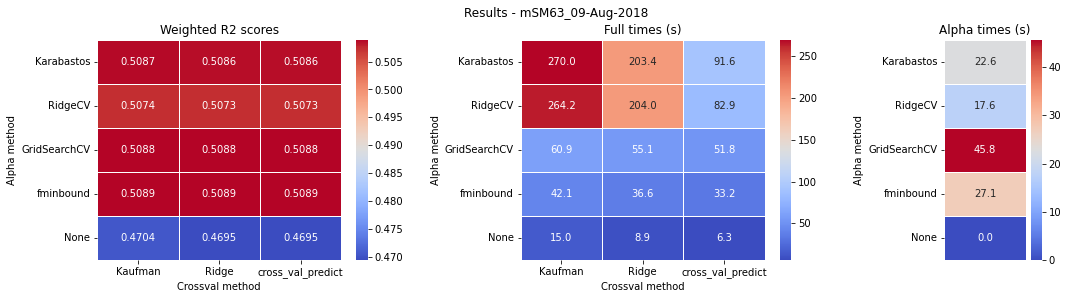

In [5]:
alphas, preds, scores, alpha_times, pred_times = rb.load_results(['alphas', 'preds', 'scores', 'alpha_times', 'pred_times'], opts)  # Load results - useful if loading already analyzed sessions

sum_fig, sum_ax = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(17,4.5))
plt.suptitle(f'Results - {opts["rec_name"] }')

scores_df = rb.unstack(pd.Series(scores))
scores_plot = sns.heatmap(scores_df, annot=True, fmt='.4f', cmap="coolwarm", linewidth=.5, ax=sum_ax[0])
scores_plot.set(title='Weighted R2 scores', xlabel='Crossval method', ylabel='Alpha method')

times_df = rb.unstack(pd.Series(pred_times))
times_plot = sns.heatmap(times_df, annot=True, fmt='.1f', cmap="coolwarm", linewidth=.5, ax=sum_ax[1])
times_plot.set(title='Full times (s)', xlabel='Crossval method', ylabel='Alpha method')

alpha_times_df = pd.Series(alpha_times).to_frame();
alpha_times_plot = sns.heatmap(alpha_times_df, annot=True, fmt='.1f', cmap="coolwarm", linewidth=.5, ax=sum_ax[2], xticklabels=False)
alpha_times_plot.set(title='Alpha times (s)', ylabel='Alpha method');

plt.subplots_adjust(bottom=0.2, wspace=0.5)
rb.save_fig(sum_fig, opts, name=f'rb_results_{opts["rec_name"]}') # Save plot

### Compute score maps

In [13]:
maps = {}
rng = np.random.default_rng(seed=4)
trial_idx = rng.permutation(int(len(data) / opts['frames_per_trial']))
frame_idx = np.arange(len(data))
frame_idx = frame_idx.reshape(-1, opts['frames_per_trial'])
trials = trial_idx[:opts['sample_trials']]
frame_idx = frame_idx[trials, :].flatten()

for crossval_method in opts['crossval_mets']:
    for alpha_method in tqdm(opts['alpha_mets'], desc=f'Computing maps for {crossval_method} method'):
        maps[crossval_method, alpha_method] = rb.model_corr(data, preds[crossval_method, alpha_method], opts, frame_idx)

Computing maps for cross_val_predict method: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


### Plot score maps

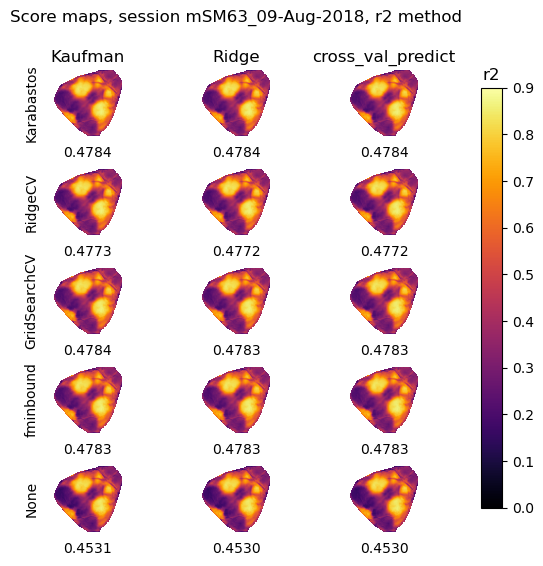

In [14]:
score_fig, score_ax = plt.subplots(len(opts['alpha_mets']), len(opts['crossval_mets']), figsize=(7, 6))
plt.suptitle(f'Score maps, session {opts["rec_name"]}, {opts["map_met"]} method')


[axi.grid(False) for axi in score_ax.ravel()]
[axi.spines[['bottom', 'left', 'right', 'top']].set_visible(False) for axi in score_ax.ravel()]
[axi.set_xticks([]) for axi in score_ax.ravel()]
[axi.set_yticks([]) for axi in score_ax.ravel()]

plots = {}
for nx, crossval_method in enumerate(opts['crossval_mets']):
    for ny, alpha_method in enumerate(opts['alpha_mets']):
        plots[ny, nx] = score_ax[ny, nx].imshow(maps[crossval_method, alpha_method], cmap='inferno', vmin=0, vmax=0.9)
        score_ax[ny, nx].set_xlabel(f'{np.nanmean(maps[crossval_method, alpha_method]):.4f}')
        if ny == 0: score_ax[ny, nx].set_title(crossval_method)
        if nx == 0: 
            score_ax[ny, nx].set_ylabel(alpha_method)

score_fig.subplots_adjust(left=0.2, right=0.8, hspace=0.5)
cbar_ax = score_fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = score_fig.colorbar(plots[0, 0], cax=cbar_ax, orientation='vertical')
cbar_ax.set_title(opts["map_met"]);

rb.save_fig(score_fig, opts, name=f'rb_corrs_{opts["rec_name"]}_{opts["map_met"]}') # Save plot